In [301]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

if False:
    import os
    # Turn off GPU
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
    gpu = False
else:
    gpu = True

from tensorflow import keras
from copy import deepcopy
import tensorflow as tf
from glob import glob
import numpy as np
import os

gpus = tf.config.experimental.list_physical_devices('GPU')

print(gpus)

if gpu:
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=(1024 * 3))])

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [302]:
from glob import glob

models = sorted(glob("model-saved\\*2023\\*[!.dict]"))
models[:5], len(models)

(['model-saved\\01-03-2023\\deeplabv3+_1_lr_0.001_alpha_0.5_256x256_layer_11_binary_Skip',
  'model-saved\\01-03-2023\\deeplabv3+_2_lr_0.001_alpha_0.5_256x256_layer_11_binary_Skip',
  'model-saved\\02-03-2023\\deeplabv3+_0_lr_0.001_alpha_0.75_256x256_layer_6_binary_Skip',
  'model-saved\\02-03-2023\\deeplabv3+_3_lr_0.001_alpha_0.5_256x256_layer_11_binary_Skip',
  'model-saved\\02-03-2023\\deeplabv3+_4_lr_0.001_alpha_0.5_256x256_layer_11_binary_Skip'],
 90)

In [303]:
from utils import data_utils

DATA_DIR = "utils/_split_/_type_"
IMG_SIZE = (256, 256)
train_val_X = sorted(glob(DATA_DIR.replace("_split_", "train-val").replace("_type_", "img") + "\\*"))
train_val_Y = sorted(glob(DATA_DIR.replace("_split_", "train-val").replace("_type_", "mask") + "\\*"))

# test_X = sorted(glob(DATA_DIR.replace("_split_", "test").replace("_type_", "img") + "\\*"))
# test_Y = sorted(glob(DATA_DIR.replace("_split_", "test").replace("_type_", "mask") + "\\*"))


# test_data = data_utils.load_testset(test_X, test_Y, IMAGE_SIZE=IMG_SIZE, BATCH_SIZE=1, REMAP="binary")

In [350]:
import numpy as np
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def confusion_matrix(y_true, y_pred):
    # True positive 1 & 1
    TP = np.bitwise_and(
        (y_true == 1), (y_pred == 1)).sum()
    # False positive 0 & 1
    FP = np.bitwise_and(
        (y_true == 0), (y_pred == 1)).sum()
    # True negative 0 & 0
    TN = np.bitwise_and(
        (y_true == 0), (y_pred == 0)).sum()
    # False negative 1 & 0
    FN = np.bitwise_and(
        (y_true == 1), (y_pred == 0)).sum()

    output = np.array([[TN, FP], [FN, TP]])

    return output, output.sum()

def run_confusion_matrix(model, dataset, normalize=False):
    BATCH = IMG = 0
    MASK = 1

    matrix = np.array([[0, 0], [0, 0]])
    total = 0

    for data in dataset:
        y_true = np.reshape(data[MASK][BATCH], (256, 256)) \
            .flatten()
        y_pred = model.predict(data[IMG], verbose=0, workers=100)[BATCH] \
            .astype(np.uint8).flatten()

        matrixPartial, totalPartial = confusion_matrix(y_true, y_pred)

        matrix += matrixPartial
        total += totalPartial

    if normalize:
        matrix = matrix / total
    
    return matrix

def mIOU(y_true, y_pred):
    ulabels = np.unique(y_true)[:-1]

    iou = np.zeros(len(ulabels))

    for k, u in enumerate(ulabels):
        inter = (y_true == u) & (y_pred == u)
        union = (y_true == u) | (y_pred == u)

        iou[k] = inter.sum() / union.sum()

    return iou.mean()

def run_mIOU(model, dataset):
    BATCH = IMG = 0
    MASK = 1
    
    mIOUList = []

    for data in dataset:
        y_true = np.reshape(data[MASK][BATCH], (256, 256)) \
            .flatten()
        y_pred = model.predict(data[IMG], verbose=0, workers=100)[BATCH] \
            .astype(np.uint8).flatten()

        mIOUList.append(mIOU(y_true, y_pred))
    return np.array(mIOUList).round(5)

class plot_distribution():

    def __init__(self, plot_name):
        self.plot_name = plot_name
        self.data = {}

    def add_plot(self, name, data):
        self.data[name] = data

    def show_plot(self, save=False):
        fig, ax = plt.subplots()
        ax.set_title(self.plot_name)
        
        sns.set_context("paper")
        
        ax.set_xlabel("mIOU")
        ax.set_ylabel("mIOU frequency")

        ax = sns.histplot(data=self.data, legend=True, kde=True, 
                          common_norm=False, stat="count", ax=ax,
                          palette=sns.color_palette(n_colors=5))

        if save:
            fig.savefig("plot/"+self.plot_name+".svg", format="svg")
        
        self.data = {}
        plt.show()

In [308]:
outlier_dict = {}
mIOU_dict = {}
import json
from models import deeplabV3
IMG_SIZE = (256, 256)

for modelPath in models:
    train_val_data = data_utils.load_dataset(train_val_X, train_val_Y, 
                                             IMAGE_SIZE=IMG_SIZE, BATCH_SIZE=1,
                                             REMAP="binary", N_FOLDS=5, SEED=42)
            
    for fold, (trainDataset, valDataset, n_classes) in enumerate(train_val_data):
        # model-saved\\01-03-2023\\deeplabv3+_1_lr_0.001_alpha_0.5_256x256_layer_11_binary_Skip
        modelName = modelPath.split("\\")[-1]

        modelFold = int(modelName.split("_")[1])
        modelLr = modelName.split("_")[3]
        modelAlpha = float(modelName.split("_")[5])
        modelLayer = modelName.split("_")[8]

        if (fold != modelFold):
            continue

        mobileLayers = {"shallowLayer": "block_2_project_BN",
                    "deepLayer": f"block_{modelLayer}_project_BN"}

        model = deeplabV3(imageSize=IMG_SIZE, nClasses=n_classes, alpha=modelAlpha, 
                            withArgmax=True, mobileLayers=mobileLayers)
        model.load_weights(modelPath)

        tempList = run_mIOU(model, valDataset)

        tempDict = {
            "Name":modelName,
            "Mean": np.mean(tempList).round(5),
            "Variance": np.var(tempList).round(5),
            "StandardDeviation": np.std(tempList).round(5),
            "Median": np.median(tempList),
            "IoU_ValSet": tempList
        }

        print(f"{tempDict['Name']} | Mean {tempDict['Mean']} | Variance {tempDict['Variance']} | Standard Deviation {tempDict['StandardDeviation']}")

        try:
            mIOU_dict[f"alpha_{modelAlpha}_layer_{modelLayer}"] += [tempDict]
        except (KeyError):
            mIOU_dict[f"alpha_{modelAlpha}_layer_{modelLayer}"] = [tempDict]

        tempDict = tempList = None

# for key in mIOU_dict.keys():
#     with open(key + '.json', 'w') as fout:
#         json.dump({key:mIOU_dict[key]}, fout)

deeplabv3+_1_lr_0.001_alpha_0.5_256x256_layer_11_binary_Skip | Mean 0.89485 | Variance 0.00179 | Standard Deviation 0.04232
deeplabv3+_2_lr_0.001_alpha_0.5_256x256_layer_11_binary_Skip | Mean 0.89582 | Variance 0.0022 | Standard Deviation 0.0469


KeyboardInterrupt: 

In [ ]:
outlier_dict

In [60]:
import json

newDict = {}
for key in mIOU_dict.keys():
    newDict[key] = []
    for dicts in mIOU_dict[key]:
        keys = list(dicts.keys())
        newDict[key].append({
            keys[0]:{
                keys[1]: dicts[keys[1]],
                keys[2]: dicts[keys[2]],
                keys[3]: dicts[keys[3]],
                "IoU" : dicts[keys[0]]}})
        
for key in newDict.keys():
    with open(key + '.json', 'w') as fout:
        json.dump({key:newDict[key]}, fout)

In [3]:
from glob import glob

files = sorted(glob("*.json"))
files[:3]

['alpha_0.5_layer_10.json',
 'alpha_0.5_layer_11.json',
 'alpha_0.5_layer_6.json']

In [187]:
import json

i = 0

metricDict = {}

for file in files:
    with open(file, 'r') as fin:
        # read json with a model cross validation and 
        data = json.load(fin)

        split = list(data.keys())[0]
        
        auxDict = {}

        # remove list of IoU
        for key in data[split].keys():
            # del data[split][key]["mIOU_ValSet"]
            data[split][key]["name"] = key

            fold = "fold " + key.split("_")[1]

            auxDict[fold] = data[split][key]

        metricDict[split] = auxDict

len(metricDict)

17

In [188]:
list(metricDict.keys())

['alpha_0.5_layer_10',
 'alpha_0.5_layer_11',
 'alpha_0.5_layer_6',
 'alpha_0.5_layer_7',
 'alpha_0.5_layer_8',
 'alpha_0.5_layer_9',
 'alpha_0.75_layer_10',
 'alpha_0.75_layer_11',
 'alpha_0.75_layer_6',
 'alpha_0.75_layer_7',
 'alpha_0.75_layer_8',
 'alpha_0.75_layer_9',
 'alpha_1.0_layer_10',
 'alpha_1.0_layer_6',
 'alpha_1.0_layer_7',
 'alpha_1.0_layer_8',
 'alpha_1.0_layer_9']

In [339]:
def getOutliers(tempList):
    if not isinstance(tempList, np.array.__class__):
        tempList = np.array(tempList)

    q1, q3 = np.quantile(tempList, [.25, .75])

    outlierLess = q1 - 1.5 * (q3-q1)
    outlierMore = q3 + 1.5 * (q3-q1)

    outlier_index = np.logical_or(tempList <= outlierLess, tempList >= outlierMore)

    outlierList = tempList[outlier_index]

    return outlierList, outlier_index

alpha_0.5_layer_10


,Mean,StandardDeviation,Outliers
fold 0,0.895453,0.043466,13.0
fold 1,0.893912,0.042844,6.0
fold 2,0.893866,0.046426,19.0
fold 3,0.894256,0.044667,10.0
fold 4,0.894428,0.045849,11.0


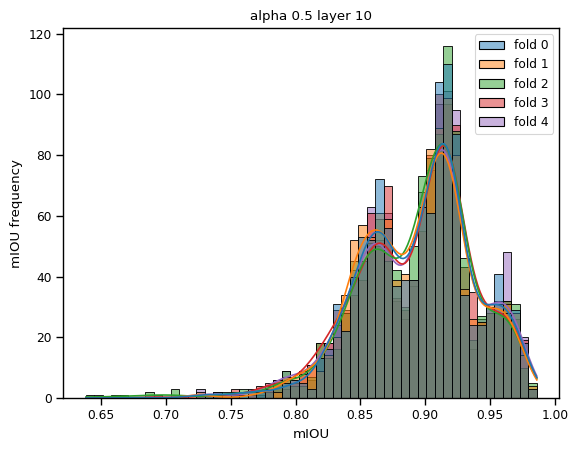

alpha_0.5_layer_11


,Mean,StandardDeviation,Outliers
fold 0,0.895189,0.043645,16.0
fold 1,0.894850,0.042321,9.0
fold 2,0.895824,0.046904,18.0
fold 3,0.894009,0.044042,9.0
fold 4,0.894658,0.045857,14.0


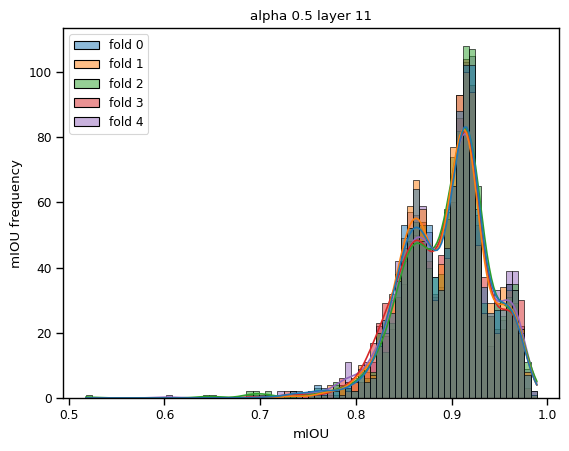

alpha_0.5_layer_6


,Mean,StandardDeviation,Outliers
fold 0,0.891071,0.044869,16.0
fold 1,0.889081,0.043990,5.0
fold 2,0.891021,0.047516,19.0
fold 3,0.890749,0.045845,15.0
fold 4,0.891774,0.046766,15.0


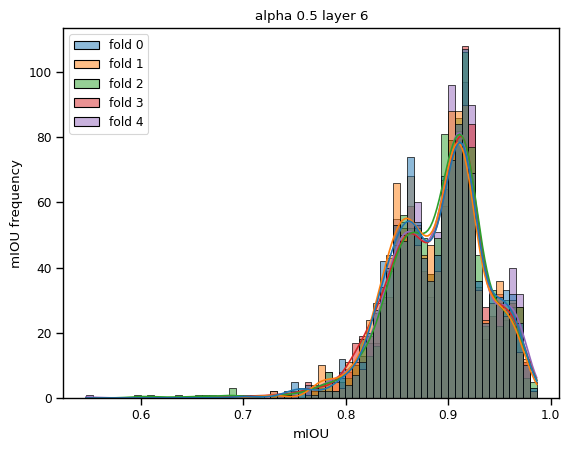

alpha_0.5_layer_7


,Mean,StandardDeviation,Outliers
fold 0,0.892497,0.044756,17.0
fold 1,0.891731,0.043130,6.0
fold 2,0.892902,0.046839,19.0
fold 3,0.891231,0.045182,11.0
fold 4,0.891271,0.046450,13.0


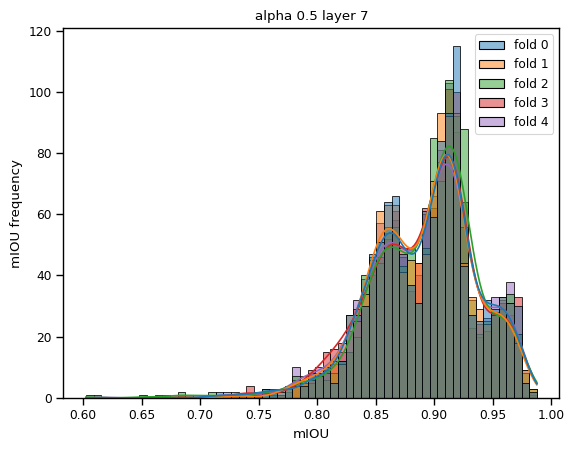

alpha_0.5_layer_8


,Mean,StandardDeviation,Outliers
fold 0,0.894318,0.044080,15.0
fold 1,0.893925,0.042434,8.0
fold 2,0.894109,0.047096,20.0
fold 3,0.892843,0.044307,9.0
fold 4,0.894315,0.046017,13.0


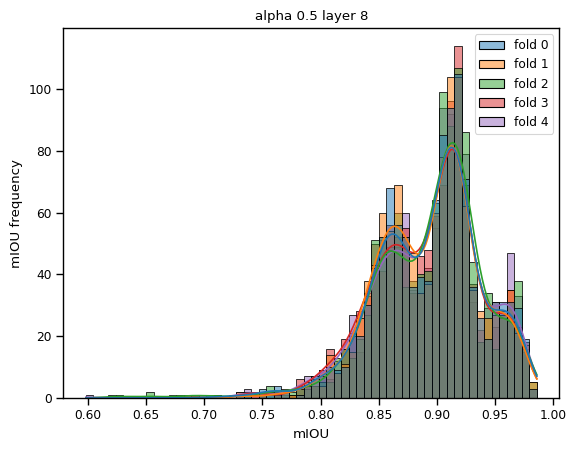

alpha_0.5_layer_9


,Mean,StandardDeviation,Outliers
fold 0,0.895482,0.043815,15.0
fold 1,0.894183,0.042473,7.0
fold 2,0.892616,0.047674,19.0
fold 3,0.894376,0.044615,13.0
fold 4,0.895218,0.045434,12.0


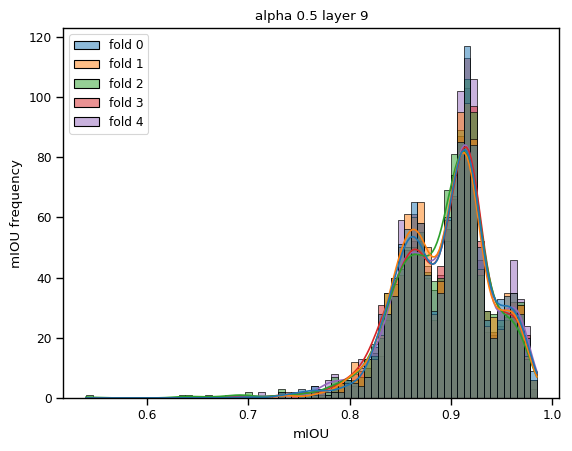

alpha_0.75_layer_10


,Mean,StandardDeviation,Outliers
fold 0,0.898802,0.042718,12.0
fold 1,0.897388,0.041880,6.0
fold 2,0.897391,0.046085,19.0
fold 3,0.897610,0.043535,8.0
fold 4,0.897508,0.045231,13.0


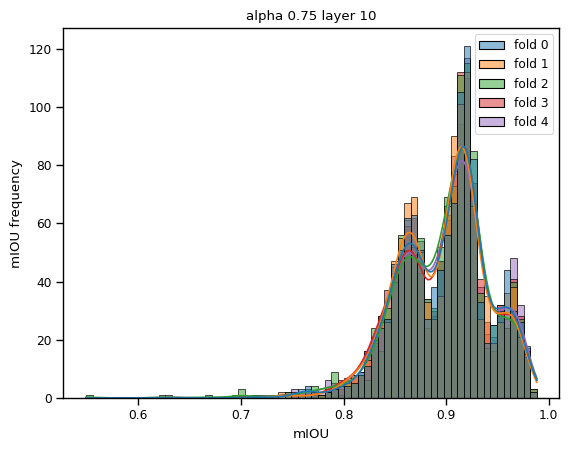

alpha_0.75_layer_11


,Mean,StandardDeviation,Outliers
fold 0,0.899226,0.042442,10.0
fold 1,0.897252,0.041780,5.0
fold 2,0.897415,0.046114,18.0
fold 3,0.897998,0.043479,9.0
fold 4,0.898283,0.045245,13.0


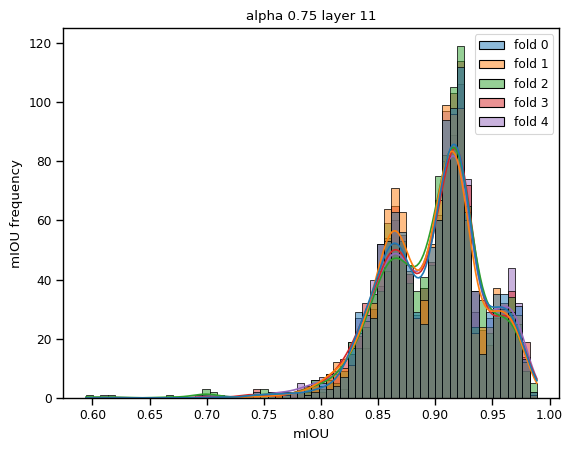

alpha_0.75_layer_6


,Mean,StandardDeviation,Outliers
fold 0,0.894811,0.043839,16.0
fold 1,0.892223,0.043211,9.0
fold 2,0.893793,0.046860,22.0
fold 3,0.892972,0.045063,13.0
fold 4,0.894102,0.046609,13.0


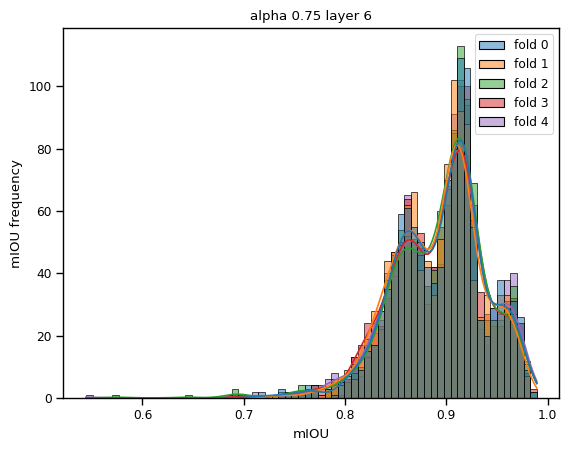

alpha_0.75_layer_7


,Mean,StandardDeviation,Outliers
fold 0,0.896659,0.043576,14.0
fold 1,0.895456,0.042298,5.0
fold 2,0.894442,0.046973,19.0
fold 3,0.895278,0.044566,10.0
fold 4,0.895953,0.045677,14.0


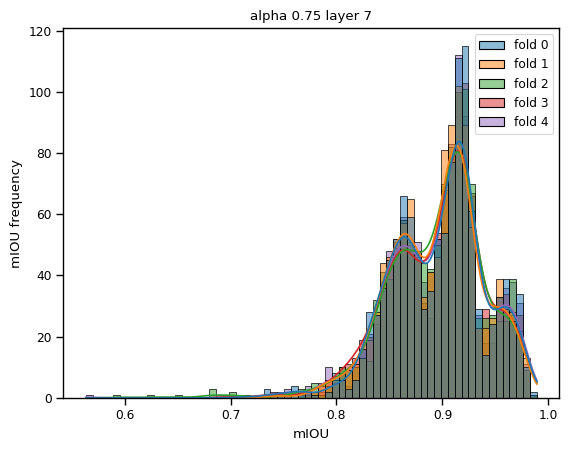

alpha_0.75_layer_8


,Mean,StandardDeviation,Outliers
fold 0,0.897924,0.042985,12.0
fold 1,0.896564,0.041910,6.0
fold 2,0.895954,0.046554,19.0
fold 3,0.895532,0.044260,10.0
fold 4,0.894146,0.046002,10.0


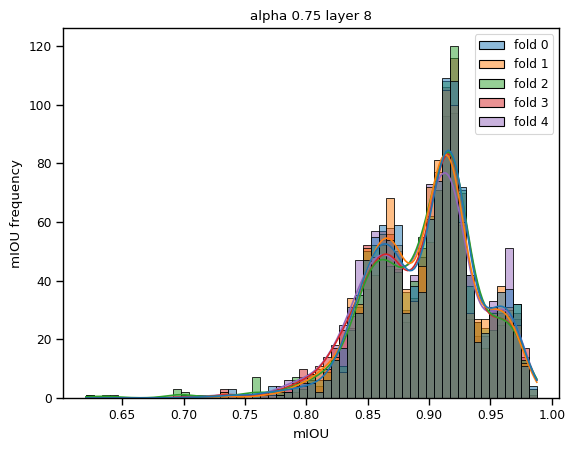

alpha_0.75_layer_9


,Mean,StandardDeviation,Outliers
fold 0,0.898327,0.042367,12.0
fold 1,0.896065,0.042739,8.0
fold 2,0.897007,0.045428,18.0
fold 3,0.896933,0.043431,8.0
fold 4,0.896913,0.045571,12.0


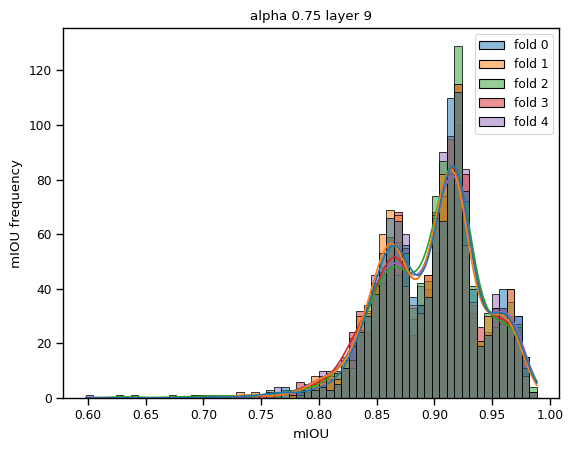

alpha_1.0_layer_10


,Mean,StandardDeviation,Outliers
fold 0,0.898603,0.042534,11.0
fold 1,0.897791,0.041467,6.0
fold 2,0.898296,0.045120,16.0
fold 3,0.897328,0.043657,9.0


C:\Users\rafae\AppData\Local\Temp\ipykernel_4568\2119147507.py:93: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  ax = sns.histplot(data=self.data, legend=True, kde=True,


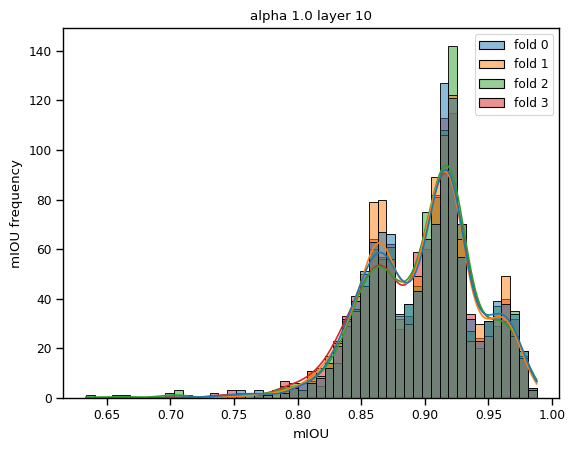

alpha_1.0_layer_6


,Mean,StandardDeviation,Outliers
fold 0,0.894270,0.043537,13.0
fold 1,0.894068,0.042506,5.0
fold 2,0.813601,0.070098,32.0
fold 3,0.893736,0.044492,8.0
fold 4,0.895138,0.046666,12.0


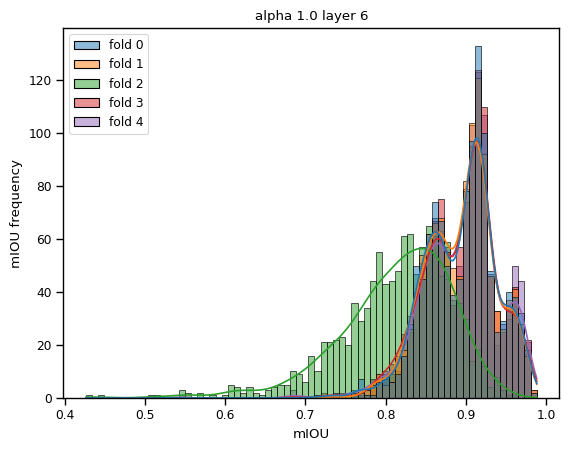

alpha_1.0_layer_7


,Mean,StandardDeviation,Outliers
fold 0,0.896334,0.043235,13.0
fold 1,0.896455,0.042268,7.0
fold 2,0.896592,0.045817,20.0
fold 3,0.896203,0.044209,12.0
fold 4,0.896622,0.045467,13.0


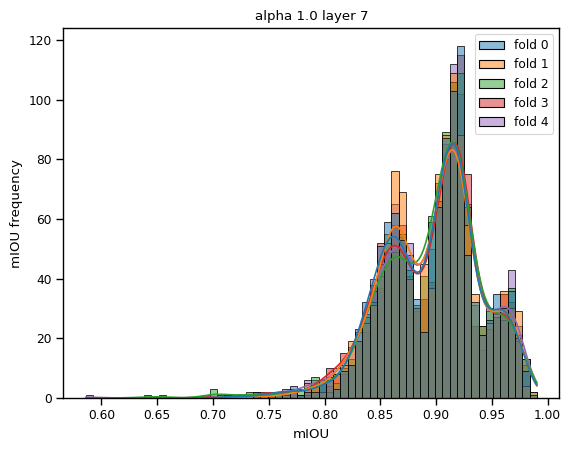

alpha_1.0_layer_8


,Mean,StandardDeviation,Outliers
fold 0,0.897208,0.042943,12.0
fold 1,0.896910,0.042157,6.0
fold 2,0.896271,0.045986,19.0
fold 3,0.896666,0.043403,8.0
fold 4,0.896889,0.045295,13.0


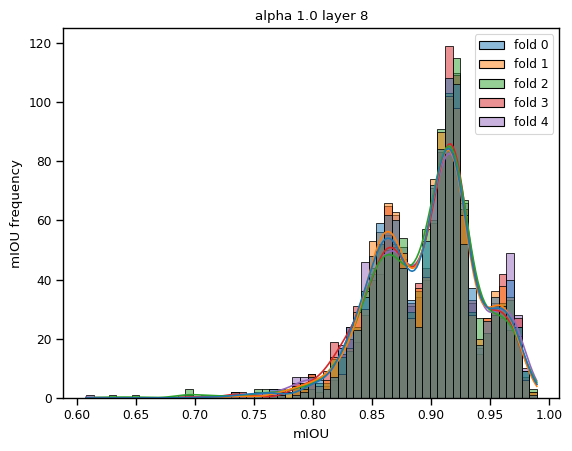

alpha_1.0_layer_9


,Mean,StandardDeviation,Outliers
fold 0,0.896456,0.043076,11.0
fold 1,0.897645,0.041621,7.0
fold 2,0.897635,0.045143,17.0
fold 3,0.897410,0.043318,9.0
fold 4,0.897353,0.045312,12.0


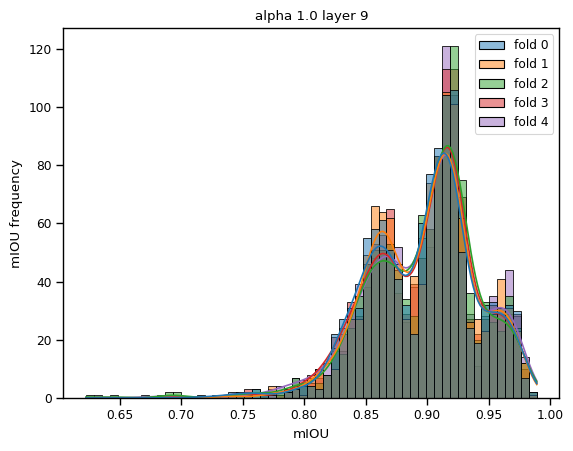

In [364]:
from IPython.display import display
import pandas as pd

keys = list(metricDict.keys())

for key in keys:
    key = key.split("_")

    split = f"alpha_{key[1]}_layer_{key[3]}"

    plotOBJ = plot_distribution(split.replace("_", " "))

    dictAux = {}
    print(split)
    for fold in sorted(metricDict[split].keys()):
        mIOUValues = np.array(metricDict[split][fold]["mIOU_ValSet"])

        outlierList, outlier_index = getOutliers(mIOUValues)
        lenOutliers = len(outlierList)
        

        dictAux[fold] = {
            "Mean": np.mean(mIOUValues),
            "StandardDeviation": np.std(mIOUValues),
            "Outliers": lenOutliers}

        # mIOUValues = mIOUValues[~outlier_index]

        plotOBJ.add_plot(fold, mIOUValues)

    df = pd.DataFrame(dictAux).transpose()
    display(df)

    plotOBJ.show_plot(save=True)

In [352]:
mIOUList = run_mIOU(model, valDataset)

Mean: 0.8948
Variance: 0.0018
Standard Deviation: 0.0423


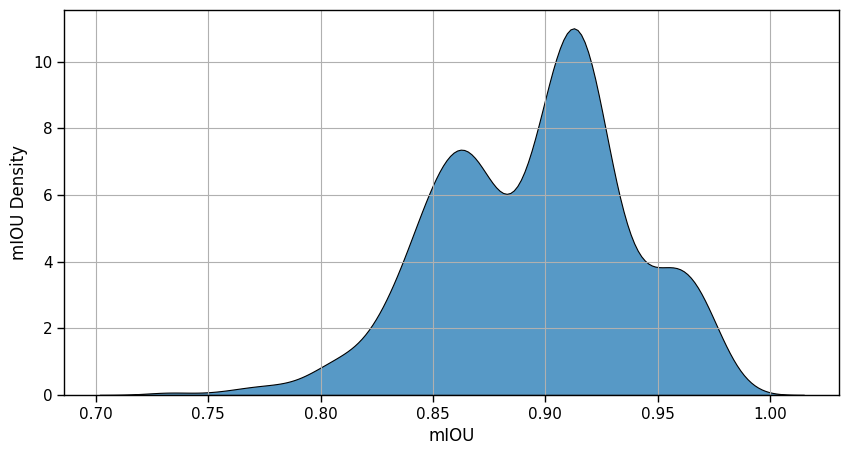

In [32]:
plot_distribution(mIOU_dict['alpha_0.5_layer_11'][0]['deeplabv3+_1_lr_0.001_alpha_0.5_256x256_layer_11_binary_Skip'])

[[0.54493827 0.00648648]
 [0.00752099 0.44105427]]


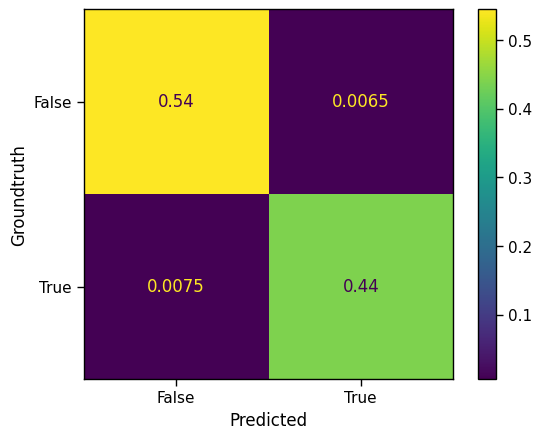

In [34]:
matrix = run_confusion_matrix(model, valDataset, normalize=True)
print(matrix)

disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=["False", "True"])
disp.plot()
disp.ax_.set(xlabel='Predicted', ylabel='Groundtruth')
plt.show()

[[21298705   210006]
 [  243970 16641329]]


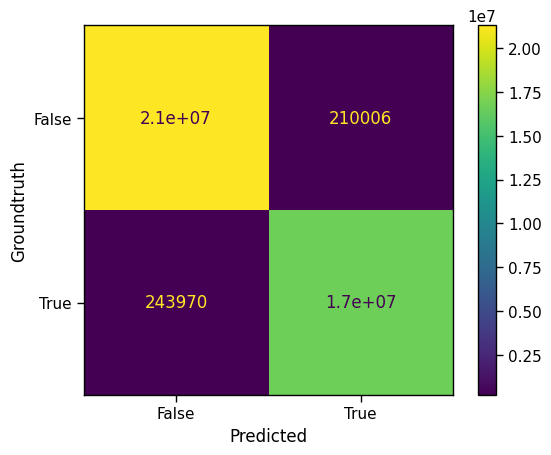

In [357]:
matrix = run_confusion_matrix(model, test_data, normalize=False)
print(matrix)

disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=["False", "True"])
disp.plot()
disp.ax_.set(xlabel='Predicted', ylabel='Groundtruth')
plt.show()